In [ ]:
# in this notebook, we load two cluster assignments, create dictionaries using the shared examples only based on their keys, and measure their similarities.

In [13]:
# let's load a few important packages for checking the cluster similarities
import numpy as np
import pandas as pd
import os
import sys
import json
from collections import Counter
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples

In [14]:
# let's load the target/ground-truth cluster assignments. it's in `root_id_type_dict.pkl` file.
import pickle
root_id_type_dict = pickle.load(open('root_id_type_dict.pkl', 'rb'))

In [15]:
# let's load the estimated cluster assignments from `cluster_assignment_dict.npy`
pca_cluster_assignment_dict = np.load('pca_cluster_assignment_dict.npy', allow_pickle=True).item()
lv_cluster_assignment_dict = np.load('cluster_assignment_dict.npy', allow_pickle=True).item()

In [16]:
# first, let's create a dictionary of the keys of `root_id_type_dict` mapped to integer indices.
root_id_type_dict_keys = list(root_id_type_dict.keys())
root_id_type_dict_keys_dict = {root_id_type_dict_keys[i]: i for i in range(len(root_id_type_dict_keys))}

In [17]:
list(pca_cluster_assignment_dict.keys())[1]

720575940631267655

In [18]:
shared_root_ids = list(set(root_id_type_dict.keys())
                       .intersection(set(pca_cluster_assignment_dict.keys())
                                     .intersection(set(lv_cluster_assignment_dict.keys()))))

In [19]:
root_id_type_dict_cluster_strings = list(set(root_id_type_dict.values()))
cluster_string_to_cid = dict([(cluster_string, cid) 
                              for cid, cluster_string
                              in enumerate(root_id_type_dict_cluster_strings)])
cid_to_cluster_string = dict([(cid, cluster_string) 
                              for cluster_string, cid
                              in cluster_string_to_cid.items()])
print(f'there are {len(cluster_string_to_cid)} unique cluster assignments in the ground-truth data.')

there are 744 unique cluster assignments in the ground-truth data.


In [20]:
gt_assignments = np.array([cluster_string_to_cid[root_id_type_dict[root_id]] for root_id in shared_root_ids])
pca_assignments = np.array([pca_cluster_assignment_dict[root_id] for root_id in shared_root_ids])
lv_assignments = np.array([lv_cluster_assignment_dict[root_id] for root_id in shared_root_ids])

In [21]:
gt_assignments[:10], pca_assignments[:10], lv_assignments[:10]

(array([ 65, 442, 442, 430, 316, 225, 442, 360, 144, 156]),
 array([170, 849, 253, 603, 213, 599, 903, 938, 802, 829]),
 array([504, 904, 677, 765, 156,  58, 102, 219,  79, 102]))

In [23]:
print(f'# of unique cluster assignments in the ground-truth data: {len(np.unique(gt_assignments))}')
print(f'# of unique cluster assignments in the PCA data: {len(np.unique(pca_assignments))}')
print(f'# of unique cluster assignments in the LV data: {len(np.unique(lv_assignments))}')

# of unique cluster assignments in the ground-truth data: 744
# of unique cluster assignments in the PCA data: 896
# of unique cluster assignments in the LV data: 685


In [24]:
# create a random assignment by randomly permuting `target_assignment`
random_assignment_optimistic = np.random.permutation(gt_assignments)
random_assignment_pessimistic = np.random.randint(0, np.unique(gt_assignments).shape[0], gt_assignments.shape[0])

In [25]:
print(f'# of unique cluster assignments in the random assignment (optimistic): {len(np.unique(random_assignment_optimistic))}')
print(f'# of unique cluster assignments in the random assignment (pessimistic): {len(np.unique(random_assignment_pessimistic))}')

# of unique cluster assignments in the random assignment (optimistic): 744
# of unique cluster assignments in the random assignment (pessimistic): 744


In [26]:
def confusion_matrix(X, Y):
    assert len(X) == len(Y)

    unique_x = np.unique(X)
    unique_y = np.unique(Y)

    x_dict = dict([(unique_x[i], i) for i in range(len(unique_x))])
    y_dict = dict([(unique_y[i], i) for i in range(len(unique_y))])

    confusion_matrix = np.zeros((len(unique_x), len(unique_y)))

    for i in range(len(X)):
        confusion_matrix[x_dict[X[i]], y_dict[Y[i]]] += 1

    return confusion_matrix

In [27]:
from scipy.optimize import linear_sum_assignment

def compare_two_assignments(assignment_A, assignment_B):
    confusion_matrix_value = confusion_matrix(assignment_A, assignment_B)

    # Align clusters using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(confusion_matrix_value, maximize=True)
    score = confusion_matrix_value[row_ind, col_ind].sum()

    # Reorder columns of the confusion matrix to align clusters
    aligned_confusion_matrix = confusion_matrix_value[:, col_ind]

    return score, aligned_confusion_matrix

In [28]:
# compare the ground-truth assignment against (a) PCA assignment, (b) LV assignment, (c) random assignment (optimistic), and (d) random assignment (pessimistic)
score_pca, _ = compare_two_assignments(gt_assignments, pca_assignments)
score_lv, _ = compare_two_assignments(gt_assignments, lv_assignments)
score_random_optimistic, _ = compare_two_assignments(gt_assignments, random_assignment_optimistic)
score_random_pessimistic, _ = compare_two_assignments(gt_assignments, random_assignment_pessimistic)

print(f'PCA: {score_pca}')
print(f'LV: {score_lv}')
print(f'Random (optimistic): {score_random_optimistic}')
print(f'Random (pessimistic): {score_random_pessimistic}')

PCA: 3463.0
LV: 20398.0
Random (optimistic): 2243.0
Random (pessimistic): 1299.0


In [16]:
# check the similarity between PCA and LV assignments
score_pca_lv, _ = compare_two_assignments(pca_assignments, lv_assignments)

print(f"PCA vs. LV: {score_pca_lv}")

PCA vs. LV: 4502.0


In [10]:
from matplotlib import pyplot as plot

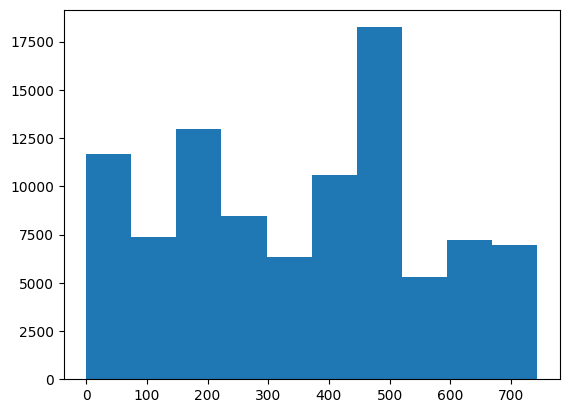

In [22]:
plot.figure()

plot.hist(gt_assignments)

plot.show()

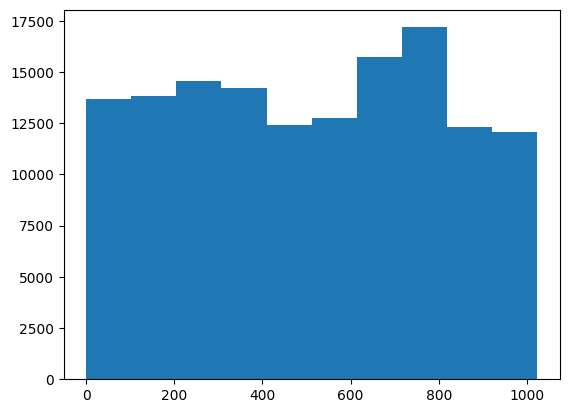

In [12]:
plot.figure()

plot.hist(lv_assignments)

plot.show()